# CNN+LSTM 전력 수요 예측 

### 목차

In [1]:
"""
1. 모듈 임포트

2. Data Export 함수 정의

3. 그래프 확인
    -각 연도별 데이터 export
    -plt 그래프 함수
    -2013
    -2014
    -2015
    -3년치 데이터 export
    -2013-2015

4. 데이터 정규화 
    -4년치 데이터 export
    -Min-Max Scaling 이용, 4년치 학습 데이터 정규화

5. 데이터 연관성 분석

6. 이상치 처리
    -이상치 확인 함수 생성
    -분위별 이상치 1차 검색
    -이상치 치환
    -처리 후 잔여 개수 확인

7. 데이터셋 편집

8. 딥러닝 모델

9. 결과 표시
    -그래프 표시
    -그래프 비교 결과
    -성능 측정 지표

10. 예측값과 실제값 결과 csv 파일 저장
    -1년 단위 저장
    -DB Import
    -1달 단위 저장, Import
    -일주일 단위 저장
"""

'\n1. 모듈 임포트\n\n2. Data Export 함수 정의\n\n3. 그래프 확인\n    -각 연도별 데이터 export\n    -plt 그래프 함수\n    -2013\n    -2014\n    -2015\n    -3년치 데이터 export\n    -2013-2015\n\n4. 데이터 정규화 \n    -4년치 데이터 export\n    -Min-Max Scaling 이용, 4년치 학습 데이터 정규화\n\n5. 데이터 연관성 분석\n\n6. 이상치 처리\n    -이상치 확인 함수 생성\n    -분위별 이상치 1차 검색\n    -이상치 치환\n    -처리 후 잔여 개수 확인\n\n7. 데이터셋 편집\n\n8. 딥러닝 모델\n\n9. 결과 표시\n    -그래프 표시\n    -그래프 비교 결과\n    -성능 측정 지표\n\n10. 예측값과 실제값 결과 csv 파일 저장\n    -1년 단위 저장\n    -DB Import\n    -1달 단위 저장, Import\n    -일주일 단위 저장\n'

### <화면 가로 확장>

In [2]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import pymysql
from sqlalchemy import create_engine

### < DB Key File Read >

In [4]:
f = open('./Electric_DB_info.txt', 'r')
lines = f.readlines()
Electric_DB_info=[]
for line in lines:
    line = line.strip()
    Electric_DB_info.append(line)
f.close()

User=Electric_DB_info[0]
PW=Electric_DB_info[1]
Export_Host=Electric_DB_info[2]
Import_Host=Electric_DB_info[3]
Port=Electric_DB_info[4]
DB=Electric_DB_info[5]

### <GPU 확인>

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

### 2. Data Export 함수 정의

In [6]:
def Data_Export(year):
    db = pymysql.connect(user=User, password=PW, host=Export_Host, db=DB, cursorclass=pymysql.cursors.DictCursor)

    cursor = db.cursor()
    if (year==2013 or year==2014 or year==2015 or year==2016):
        query = "SELECT * FROM "+str(year)+"_house1_ch1_combined_data"
        cursor.execute(query)
        db_export = cursor.fetchall()

        db_exported = pd.DataFrame(db_export)
        db_exported = db_exported.drop([db_exported.columns[0]], axis=1) # 중복 index열 삭제
        db_exported

    if (year=='3Y' or year=='4Y'):
        query = "SELECT * FROM combined_data_"+str(year)
        cursor.execute(query)
        db_export = cursor.fetchall()

        db_exported = pd.DataFrame(db_export)
        db_exported = db_exported.drop([db_exported.columns[0]], axis=1) # 중복 index열 삭제
        db_exported
        
    else:
        db_exported=='No Data exist for your input.'
        
    return db_exported

### 3. 그래프 확인

#### 각 연도별 csv 데이터 로드

In [7]:
Data_2013=Data_Export(2013)
Data_2014=Data_Export(2014)
Data_2015=Data_Export(2015)
Data_2016=Data_Export(2016)

#### Plt 그래프 함수

In [8]:
def Graph(name1, name2, year):
    font_head = {'color': 'w', 'weight': 'bold', 'size': 20}
    font_body = {'color': 'w', 'weight': 'bold', 'size': 15}

    # 1번째 그래프
    ax1 = plt.subplot(2, 1, 1)
    ax1.spines['left'].set_color('yellow')
    ax1.spines['left'].set_lw(2)
    ax1.spines['bottom'].set_color('yellow')
    ax1.spines['bottom'].set_lw(2)

    ax1.tick_params(axis='x', colors='white', size=10)
    ax1.tick_params(axis='x', colors='white', labelsize=15)
    ax1.tick_params(axis='y', colors='white', size=10)
    ax1.tick_params(axis='y', colors='white', labelsize=15)

    plt.plot(x, y1, '.-', color='y', linewidth=1)
    plt.title(name1, fontdict=font_head, pad=20)
    plt.xticks(visible=False)
    plt.ylabel('Watt',labelpad=15, fontdict=font_body)

    # 2번째 그래프
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.spines['left'].set_color('blue')
    ax2.spines['left'].set_lw(2)
    ax2.spines['bottom'].set_color('blue')
    ax2.spines['bottom'].set_lw(2)

    ax2.tick_params(axis='x', colors='white', size=10)
    ax2.tick_params(axis='x', colors='white', labelsize=15)
    ax2.tick_params(axis='y', colors='white', size=10)
    ax2.tick_params(axis='y', colors='white', labelsize=15)

    plt.plot(x, y2, '.-', color='b', linewidth=1)
    plt.title(name2, fontdict=font_head, pad=20)
    plt.xlabel('Time',labelpad=15, fontdict=font_body)
    plt.ylabel('Temp',labelpad=15, fontdict=font_body)
    plt.margins(x=0.02)
    
    if year==1:
        plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    if year==3:
        plt.xticks([0, 365, 730], labels=['2013', '2014', '2015'])

    #plt.tight_layout()
    plt.show()

#### 1년치 그래프 확인

#### 2013

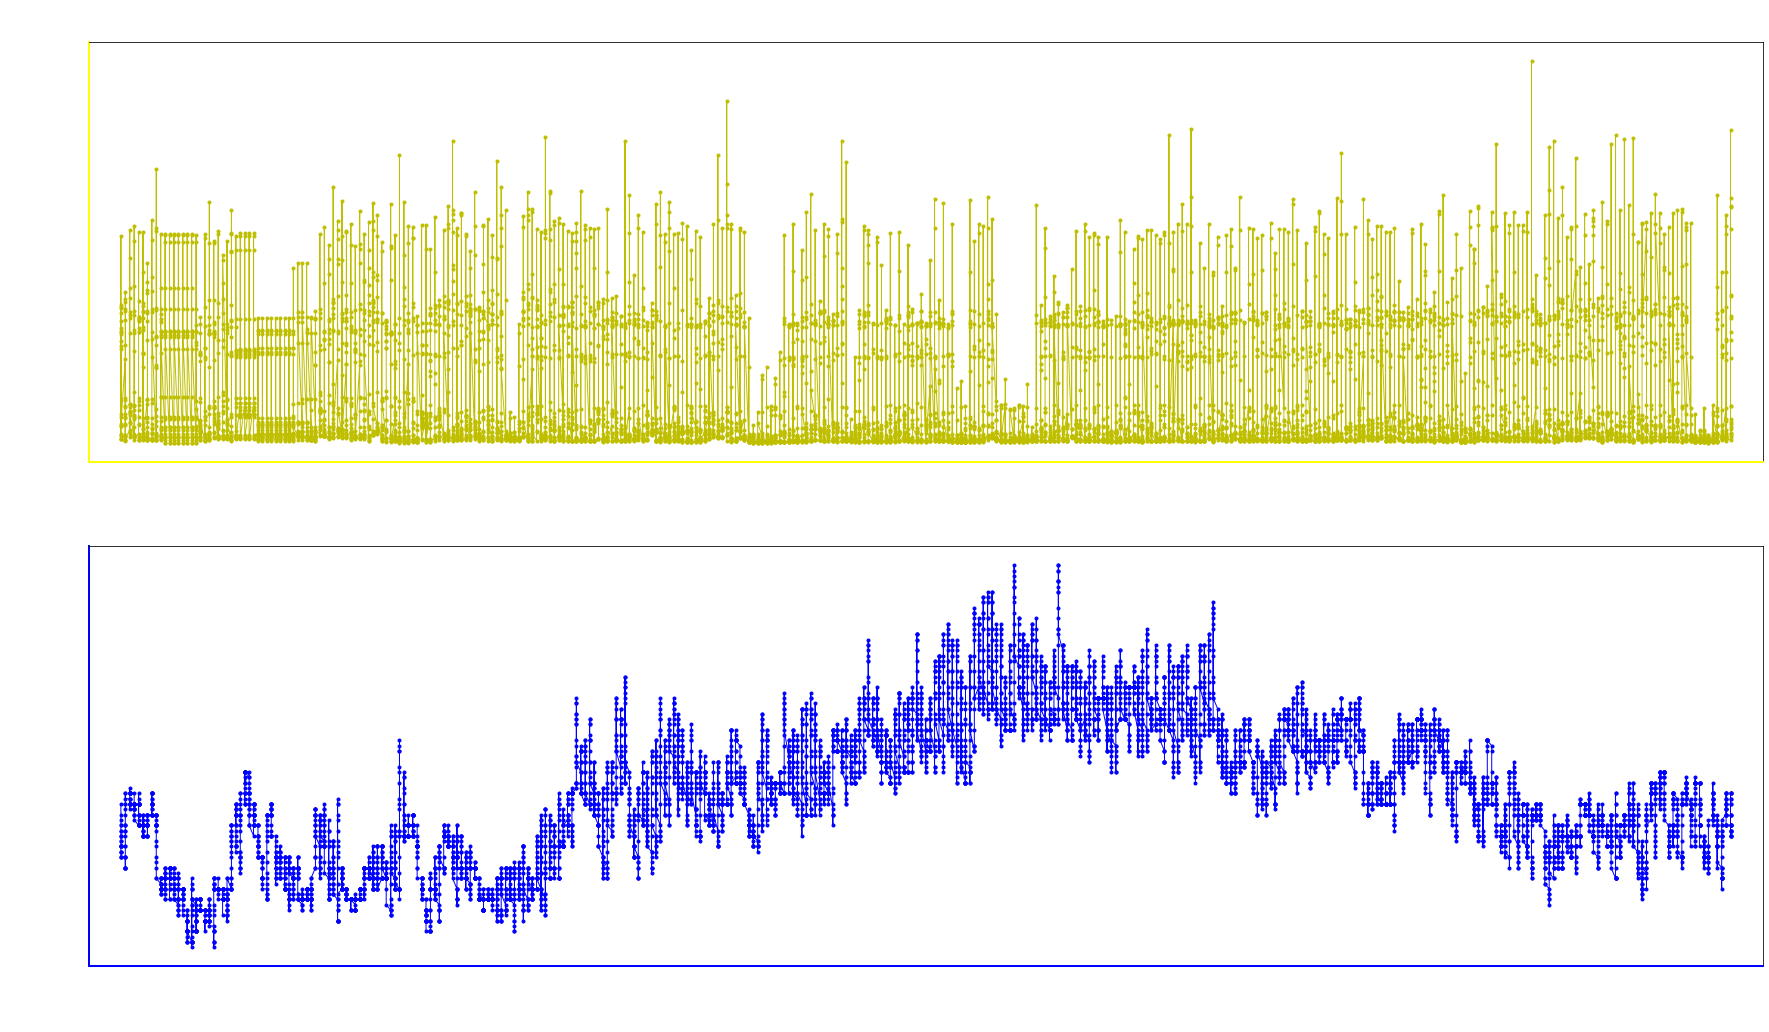

In [43]:
x = Data_2013['Graph_Date']
y1 = Data_2013['Watt']
y2 = Data_2013['Temp']

plt.figure(figsize=(30,17))

Graph("2013's Time-Watt Graph", "2013's Time-Temp Graph", 1)

#### 2014

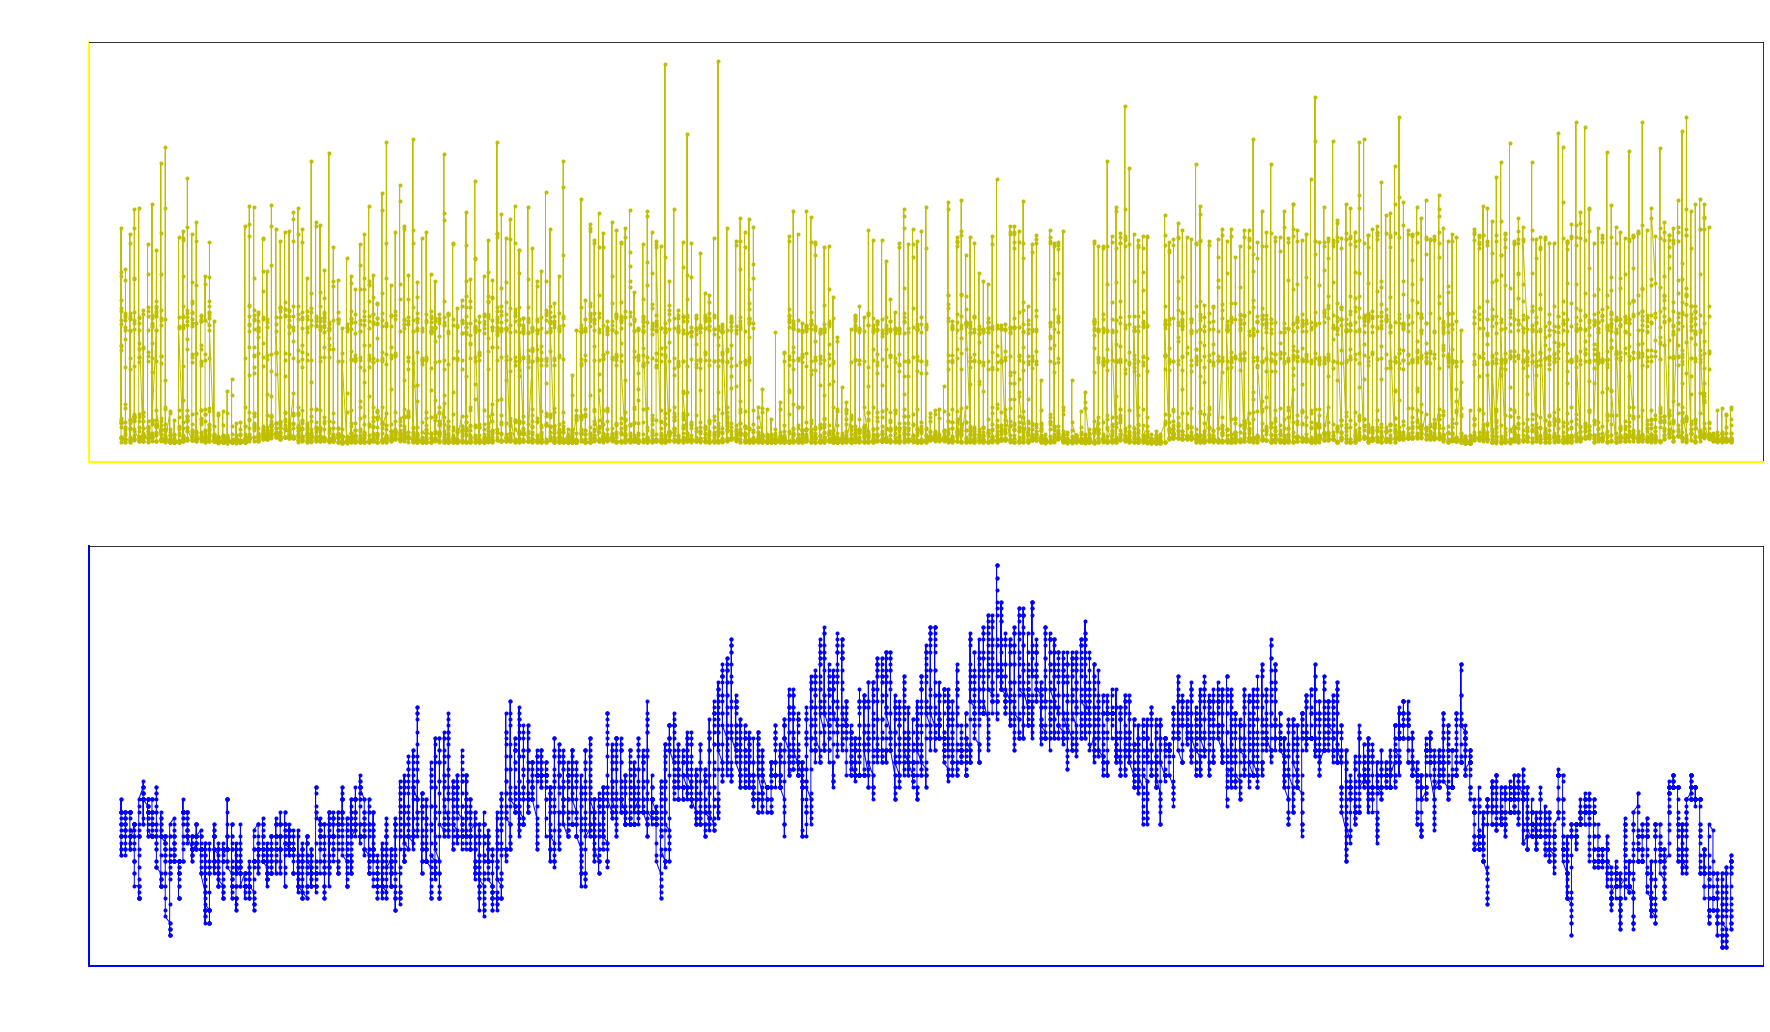

In [11]:
x = Data_2014['Graph_Date']
y1 = Data_2014['Watt']
y2 = Data_2014['Temp']

plt.figure(figsize=(30,17))

Graph("2014's Time-Watt Graph", "2014's Time-Temp Graph", 1)

#### 2015

In [12]:
x = Data_2015['Graph_Date']
y1 = Data_2015['Watt']
y2 = Data_2015['Temp']

plt.figure(figsize=(30,17))

Graph("2015's Time-Watt Graph", "2015's Time-Temp Graph", 1)

#### 3년치 데이터 그래프 확인

In [9]:
Data_3Y=Data_Export('3Y')

#### 2013-2015

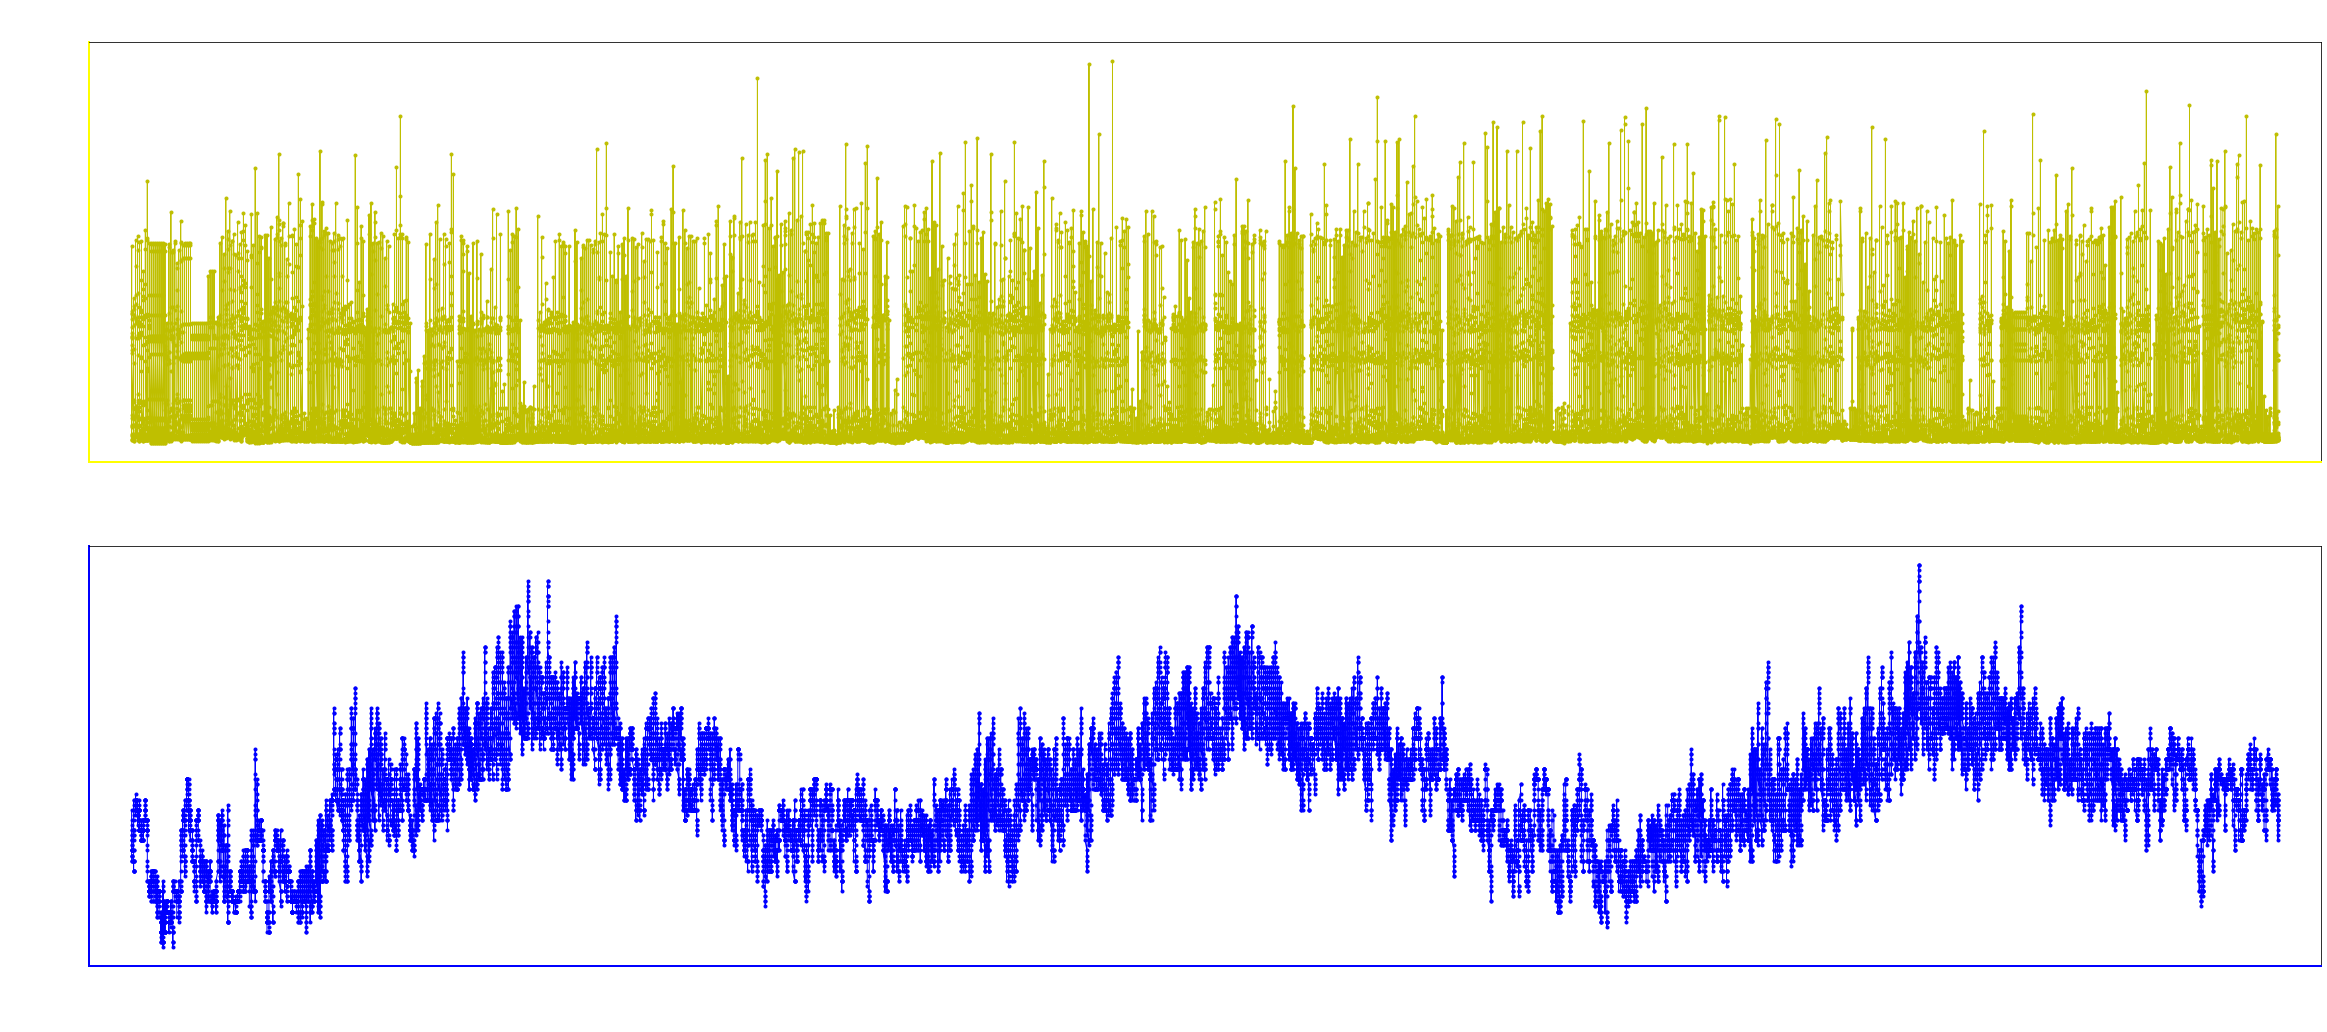

In [10]:
x = Data_3Y['Graph_Date']
y1 = Data_3Y['Watt']
y2 = Data_3Y['Temp']

plt.figure(figsize=(40,17))

Graph("13-15's Time-Watt Graph","13-15's Time-Temp Graph", 3)

### 4. 데이터 정규화

In [9]:
Data_4Y=Data_Export('4Y')

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [10]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_4Y.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['Holiday', 'Watt', 'Temp', 'CPI']
Data_4Y_scaled = scaler.fit_transform(Data_4Y[scale_cols])
Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
Data_4Y_scaled.columns = scale_cols

Data_4Y_scaled.insert(0, 'DateTime', Data_4Y['DateTime'])
Data_4Y_scaled.insert(1, 'Graph_Date', Data_4Y['Graph_Date'])
Data_4Y_scaled

DateTime  Graph_Date  Holiday      Watt      Temp       CPI
0      20130101  2013-01-01      1.0  0.270038  0.360000  0.933333
1      20130101  2013-01-01      1.0  0.268530  0.333333  0.933333
2      20130101  2013-01-01      1.0  0.263775  0.320000  0.933333
3      20130101  2013-01-01      1.0  0.011368  0.306667  0.933333
4      20130101  2013-01-01      1.0  0.010788  0.306667  0.933333
...         ...         ...      ...       ...       ...       ...
35035  20161231  2016-12-31      1.0  0.024707  0.333333  0.566667
35036  20161231  2016-12-31      1.0  0.182809  0.333333  0.566667
35037  20161231  2016-12-31      1.0  0.089781  0.306667  0.566667
35038  20161231  2016-12-31      1.0  0.049878  0.306667  0.566667
35039  20161231  2016-12-31      1.0  0.229672  0.306667  0.566667

[35040 rows x 6 columns]

### 5. 데이터 연관성 분석

In [11]:
import scipy.stats as stats

# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)

Correlation=stats.pearsonr(Data_4Y_scaled['Holiday'], Data_4Y_scaled['Watt'])
print('< Holiday - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled['Temp'], Data_4Y_scaled['Watt'])
print('< Temp - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled['CPI'], Data_4Y_scaled['Watt'])
print('< CPI - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

< Holiday - Watt >
P-value ==>> 0.000

< Temp - Watt >
P-value ==>> 0.169

< CPI - Watt >
P-value ==>> 0.000



### 6. 이상치 처리

#### 이상치 확인 함수 생성

In [12]:
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    return outlier_index_low, outlier_index_high, quantile_25, quantile_50, quantile_75

#### 분위별 이상치 1차 검색

In [13]:
print('Low Outlier ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[0]))
print('High Outlier ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[1]))

print('25% Value ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[2]))
print('50% Value ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[3]))
print('75% Value ==>> {}'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[4]))

Low Outlier ==>> Int64Index([], dtype='int64')

High Outlier ==>> Int64Index([  199,  1159,  1519,  1813,  1938,  2057,  2084,  2225,  2321,
             2341,
            ...
            33225, 33537, 33761, 34063, 34193, 34309, 34429, 34906, 34907,
            35025],
           dtype='int64', length=230)

25% Value ==>> 0.014499478018791326

50% Value ==>> 0.03932258438696207

75% Value ==>> 0.24834705950585778


#### 이상치 치환

In [14]:
high_val = get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[1].values.tolist()

for l in range(len(high_val)):
    Data_4Y_scaled['Watt'][high_val[l]] = get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[4]

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15232/1588975600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_4Y_scaled['Watt'][high_val[l]] = get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[4]


#### 이상치 처리 후 잔여 개수 확인

In [15]:
print('Quantity of Low Outlier ==>> {}\n'.format(len(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[0])))
print('Quantity of High Outlier ==>> {}\n'.format(len(get_outlier(df=Data_4Y_scaled, column='Watt', weight=1.5)[1])))

Quantity of Low Outlier ==>> 0

Quantity of High Outlier ==>> 0



### 7. 데이터셋 편집

In [16]:
TEST_SIZE = 8760 # 1년치를 테스트셋으로 사용
WINDOW_SIZE = 1 # 얼마 동안의 과거 기반의 데이터에 기반하여 다음날의 값을 예측할 것인지 설정. 1=1시간을 의미

train = Data_4Y_scaled[:-TEST_SIZE]
test= Data_4Y_scaled[-TEST_SIZE:]

In [17]:
from sklearn.model_selection import train_test_split

feature_cols = ['Holiday', 'Watt', 'Temp', 'CPI']
label_cols = ['Watt']

train_feature = train[feature_cols]
train_label = train[label_cols]

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, random_state=0, shuffle=False)

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
WINDOW_SIZE=1
BATCH_SIZE=128

In [20]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False) # 학습도 셔플 안해야 맞는게 아닌가??
valid_data = windowed_dataset(y_valid, WINDOW_SIZE, BATCH_SIZE, False)

In [21]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (128, 1, 1, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (128, 1, 1)


### 8. 딥러닝 모델

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from keras.layers.wrappers import TimeDistributed
import keras
"""
model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="causal",activation="ReLU",input_shape=[WINDOW_SIZE, 1]),
    LSTM(256, activation='ReLU',return_sequences=True),
    Bidirectional(LSTM(128, activation='ReLU', return_sequences=True), merge_mode='concat'),
    LSTM(128, activation='ReLU',return_sequences=True),
    Bidirectional(LSTM(64, activation='ReLU', return_sequences=True), merge_mode='concat'),
    LSTM(128, activation='ReLU', return_sequences = True),
    Bidirectional(LSTM(32, activation='ReLU', return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(32)),
    LSTM(32, activation='ReLU', return_sequences = False),
    Dense(1, activation='sigmoid')
                    ])
"""
model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="causal", input_shape=[WINDOW_SIZE, 1]),
    LSTM(256,return_sequences=True),
    Bidirectional(LSTM(128, return_sequences=True), merge_mode='concat'),
    LSTM(128,return_sequences=True),
    Bidirectional(LSTM(64, return_sequences=True), merge_mode='concat'),
    LSTM(128, return_sequences = True),
    Bidirectional(LSTM(32, return_sequences=True), merge_mode='concat'),
    TimeDistributed(Dense(32)),
    LSTM(32,  return_sequences = False),
    Dense(1)
                    ])

model.summary()
model.compile(loss='mean_squared_error', optimizer='Nadam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             384       
                                                                 
 lstm_7 (LSTM)               (None, 1, 256)            328704    
                                                                 
 bidirectional_3 (Bidirectio  (None, 1, 256)           394240    
 nal)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 1, 128)            197120    
                                                                 
 bidirectional_4 (Bidirectio  (None, 1, 128)           98816     
 nal)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 1, 128)           

#### Plot model 저장

In [33]:
from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=6)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=30, batch_size=32,validation_data=(valid_data), callbacks=[early_stop, checkpoint])

Epoch 1/30
    165/Unknown - 16s 36ms/step - loss: 0.0205
Epoch 00001: val_loss improved from inf to 0.01895, saving model to model\tmp_checkpoint.h5
165/165 [==============================] - 19s 54ms/step - loss: 0.0205 - val_loss: 0.0190
Epoch 2/30
164/165 [============================>.] - ETA: 0s - loss: 0.0186
Epoch 00002: val_loss improved from 0.01895 to 0.01885, saving model to model\tmp_checkpoint.h5
165/165 [==============================] - 6s 35ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 3/30
164/165 [============================>.] - ETA: 0s - loss: 0.0186
Epoch 00003: val_loss improved from 0.01885 to 0.01877, saving model to model\tmp_checkpoint.h5
165/165 [==============================] - 6s 35ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 4/30
165/165 [==============================] - ETA: 0s - loss: 0.0186
Epoch 00004: val_loss improved from 0.01877 to 0.01871, saving model to model\tmp_checkpoint.h5
165/165 [==============================] - 6s 36ms/step - lo

In [35]:
model.load_weights(filename)
pred = model.predict(test['Watt'])

pred.shape

(8760, 1)

### 9. 결과 표시

In [36]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [37]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

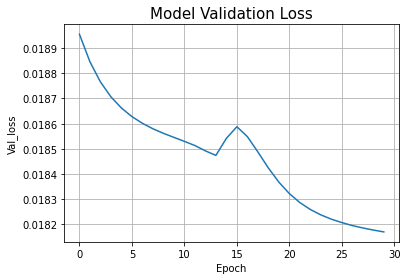

In [38]:
plt.title('Model Validation Loss', size='15')
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.savefig('./Result/CNN+LSTM/Graph/Model_Valdation_Loss.png')
plt.show

In [39]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='blue', size=15)
plt.tick_params(axis='x', colors='blue', labelsize=12)
plt.tick_params(axis='y', colors='blue', size=15)
plt.tick_params(axis='y', colors='blue', labelsize=12)

plt.plot(pred, label = 'Prediction',color='blue')

plt.xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Prediction.png')
plt.show()

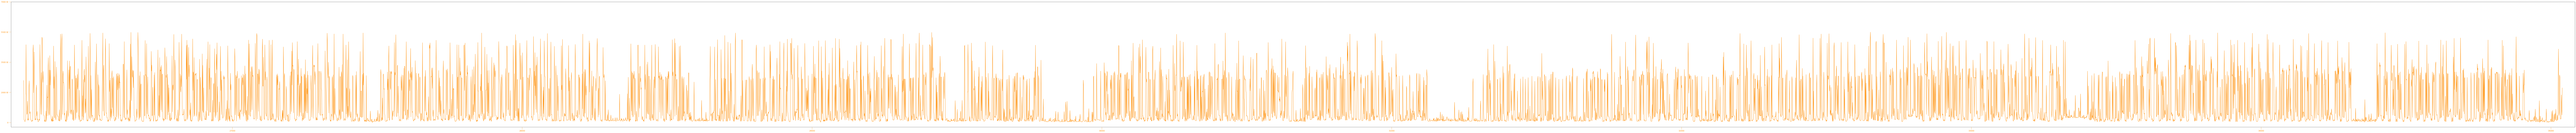

In [40]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='darkorange', size=15)
plt.tick_params(axis='x', colors='darkorange', labelsize=12)
plt.tick_params(axis='y', colors='darkorange', size=15)
plt.tick_params(axis='y', colors='darkorange', labelsize=12)

x=test['Graph_Date']

plt.plot(test['Watt'], label = 'Actual', color='darkorange')

plt.yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Actual.png')
plt.show()

TypeError: set_ticks() takes 2 positional arguments but 3 were given

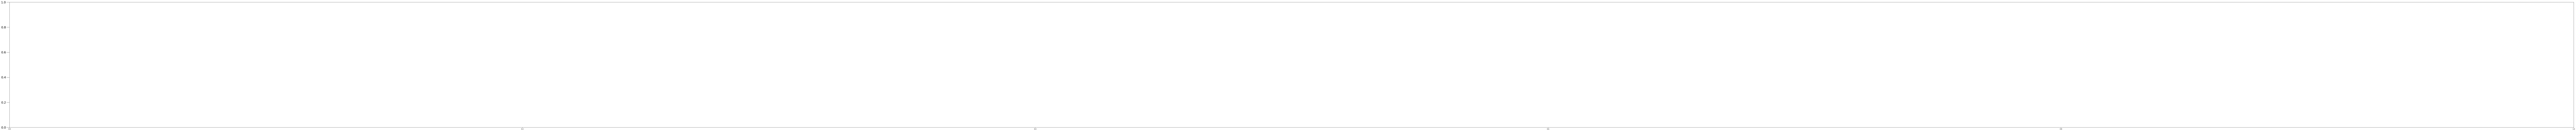

In [54]:
fig = plt.figure(figsize=(300,15)) 
ax1 = fig.add_subplot() # subplot 그래프 생성
ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8],['0', '2000 W', '3500 W', '5500 W', '7000 W'])

color1 = 'darkorange'
ax1.plot(test['Watt'], color=color1)
ax1.set_xlabel('x1', color=color1, size=20) # x1축 레이블명 표시
ax1.set_ylabel('y', size=20)
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', size=20, labelsize=20)
ax1.margins(x=0.005)
ax1.set_xticks([26280, 26280+31*24, 26280+59*24, 26280+90*24, 26280+120*24, 26280+151*24, 26280+181*24, 26280+212*24, 26280+243*24, 26280+273*24, 26280+304*24, 26280+334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정


color2 = 'blue'
ax2 = ax1.twiny()
ax2.plot(pred, color=color2)
ax2.set_xlabel('x2', color=color2, size=20) # x2축 레이블명 표시
ax2.tick_params(axis='x', size=20, labelsize=20)
ax2.margins(x=0.005)
ax2.set_xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정


plt.legend()
plt.savefig('./Result/CNN+LSTM/Graph/Pred_with_Actual.png')
plt.show()

In [ ]:
# 월 단위 그래프 분할 표시 및 저장
for m in range(1,13):
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
        
    ax2.set_title('Prediction & Actual Graph - month'+str(m), size='15')
    
    watt_list=test['Watt'].tolist()
    
    fig = plt.figure(figsize=(30,15)) 
    ax1 = fig.add_subplot() # subplot 그래프 생성
    ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W', '8500 W'])

    # Actual
    color1 = 'darkorange'
    ax1.plot(watt_list[start[m]:end[m]], color=color1, marker='.')
    ax1.tick_params(axis='x', size=20, labelsize=20)
    ax1.margins(x=0.005)
    ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.95, 1, 0, 0))
    
    # Predict
    color2 = 'blue'
    ax2 = ax1.twiny()
    ax2.plot(pred[start[m]:end[m]], color=color2, marker='.')
    ax2.tick_params(axis='x', size=20, labelsize=20)
    ax2.xaxis.set_visible(False)
    ax2.margins(x=0.005)
    ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))
    
    # 월별 xticks 설정 함수
    def xticks_list (days):
        xticks_list=[]
        for x in range(0,days+1):
            xticks_list.append(x*24)
        return xticks_list
    
    # month labels 설정 함수
    def month_labels (days):
        month_labels=[]
        for ml in range(1,days+1):
            month_labels.append(ml)
        month_labels.append('end') 
        return month_labels
    
    if (m==2):
        ax1.set_xticks(xticks_list(28), labels=month_labels(28))

    if (m==4 or m==6  or m==9 or m==11):
        ax1.set_xticks(xticks_list(30), labels=month_labels(30))
        
    if (m==1 or m==3 or m==5 or m==7 or m==8 or m==10 or m==12):
        ax1.set_xticks(xticks_list(31), labels=month_labels(31))
        
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])
    
    plt.suptitle('Prediction_with_Actual_'+str(m),fontsize=20)
    plt.grid(True)
    plt.savefig('./Result/CNN+LSTM/Graph/Prediction_with_Actual_'+str(m)+'.png')
    plt.show()

#### 그래프 비교 결과

In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim

In [ ]:
# 유사도 측정을 위한 이미지 가공
image1 = cv2.imread('./Result/CNN+LSTM/Graph/Prediction.png')
image2 = cv2.imread('./Result/CNN+LSTM/Graph/Actual.png')

tempDiff1 = cv2.subtract(image1, image2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [ ]:
# 차이 추출을 위한 뺄셈 과정
pred_list=pred.tolist()
actual_list=test['Watt'].tolist()

In [ ]:
(score, diff) = ssim(gray1, gray2, full=True)
sim_score = round(score,5)*100

print('그래프 유사도 ==>> %.3f %%' %sim_score)

#### 성능 측정 지표

In [ ]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

print('r2 >> %.4f' %r2(test['Watt'], pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE(test['Watt'], pred)) # 0에 가까워야 좋음
print('MSE >> %.4f' %MSE(test['Watt'], pred)) # 0에 가까워야 좋음
print('RMSE >> %.4f' %np.sqrt(MSE(test['Watt'], pred))) # 0에 가까워야 좋음
print('RMSLE >> %.4f' %np.sqrt(MSLE(test['Watt'], pred))) # 0에 가까워야 좋음

In [56]:
MSE = MSE(test['Watt'], pred)
RMSE = np.sqrt(MSE(test['Watt'], pred))
RMSE_pct = round(1-RMSE, 5)*100
print('RMSE 측정 정확도 ==>> %.3f %%' %RMSE_pct)

NameError: name 'MSE' is not defined

### 10. 예측값과 실제값 결과 csv 파일 저장

#### 1년 단위 데이터 저장

In [136]:
# 날짜 정보 생성
month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
datetime_list=[]

for m in range(1, 13):
    month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    for d in range(month[m]):
        d=d+1
        m=int(m)
        d=int(d)
        
        if m<=9:
            m='0'+str(m)
        if d<=9:
            d='0'+str(d)
            
        for h in range(1,25):
            elem = '2016'+'년-'+str(m)+'월-'+str(d)+'일-'+str(h)+'시'
            datetime_list.append(elem)

In [137]:
# 넘파이 어레이를 데이터 프레임으로 변환
pred_df = pd.DataFrame(pred)
actual_df = pd.DataFrame(watt_list)

In [138]:
df_for_chart = pd.DataFrame(columns=['datetime', 'pred', 'actual'])
df_for_chart['datetime']=datetime_list
df_for_chart['pred']=pred_df
df_for_chart['actual']=actual_df
df_for_chart.to_csv("./Result/CNN+LSTM/Data/Electric_Prediction_result_data_for_Chart_Year.csv", encoding='cp949')

print('Job Done!!')

Job Done!!


#### DB Import

In [139]:
db = pymysql.connect(host=Import_Host, user=User, password=PW)
cursor = db.cursor()

try:
    cursor.execute('create database result_data_cnn_lstm;')
    db.commit()
    db.close()
    print('Database has been created\n')
    
except:
    print('Database already exsist!\n')
    
db = pymysql.connect(host=Import_Host, user=User, password=PW)
cursor = db.cursor()

# csv파일 불러오기
df = pd.read_csv("./Result/CNN+LSTM/Data/Electric_Prediction_result_data_for_Chart_Year.csv", encoding = 'cp949')

# sqlalchemy를 사용해 원하는 database에 csv파일 저장
try:
    engine = create_engine("mysql+pymysql://"+User+":"+PW+"@"+Import_Host+":"+Port+"/result_data_cnn_lstm?charset=utf8", encoding = "cp949")
    conn = engine.connect()
    df.to_sql(name = "result_data_year", con = engine, index = False)
    conn.close()
    print('Table Imported')

except ValueError:
    print('Table already exists!')

print('\nJob Done!')

Database already exsist!

Table Imported

Job Done!


#### 1달 단위 데이터 저장, Import

In [140]:
db = pymysql.connect(host=Import_Host, user=User, password=PW)
cursor = db.cursor()

try:
    cursor.execute('create database result_data_cnn_lstm;')
    db.commit()
    db.close()
    print('Database has been created\n')
    
except:
    print('Database already exsist!\n')
    
#==========================================================================================================================

for m in range(1,13):
    m=int(m)
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
    
    df_for_chart = pd.DataFrame(columns=['datetime', 'pred', 'actual'])
    df_for_chart['datetime']=datetime_list[start[m]:end[m]]
    df_for_chart['pred']=pred_df[start[m]:end[m]]
    df_for_chart['actual']=actual_df[start[m]:end[m]]
        
    if m<=9:
        m=str(m)
        m='0'+m
        
    df_for_chart.to_csv("./Result/CNN+LSTM/Data/Electric_Prediction_result_data_for_Chart_"+str(m)+".csv", encoding='cp949')
    
    #=========================================================================================================================================================
    
    db = pymysql.connect(host=Import_Host, user=User, password=PW)
    cursor = db.cursor()

    # csv파일 불러오기
    df = df_for_chart

    # sqlalchemy를 사용해 원하는 database에 csv파일 저장
    try:
        engine = create_engine("mysql+pymysql://"+User+":"+PW+"@"+Import_Host+":"+Port+"/result_data_cnn_lstm?charset=utf8", encoding = "cp949")
        conn = engine.connect()
        df.to_sql(name = "result_data_"+str(m), con = engine, index = False)
        conn.close()
        print('Table Imported')
        
    except ValueError:
        print('Table already exists!')
    
#=======================================================================================================================================================

print('\nJob Done!!')

Database already exsist!

Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported
Table Imported

Job Done!!


#### 일주일 단위 데이터 저장

In [141]:
try:
    os.mkdir('./Result/CNN+LSTM/Data/Week')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [142]:
count=0
for w in range(0, 8760-168, 168):
    count=int(count)
    count+=1
    start=w
    end=w+168
    
    df_for_chart = pd.DataFrame(columns=['datetime', 'pred', 'actual'])
    df_for_chart['datetime']=datetime_list[start:end]
    df_for_chart['pred']=pred_df[start:end]
    df_for_chart['actual']=actual_df[start:end]
    
    if count<=9:
        count=str(count)
        count='0'+count
        
    df_for_chart.to_csv("./Result/CNN+LSTM/Data//Week/Electric_Prediction_result_data_for_Chart_"+str(count)+".csv", encoding='cp949')
    
print('Job Done!!')

Job Done!!
